Expectations: Please provide solutions to the questions in the cells at the end of the notebook.

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torch.optim.lr_scheduler import ExponentialLR

In [25]:
# MNIST
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    num_classes = 10
    transform_train = transforms.Compose([
        transforms.ToTensor(),
    ])

    transform_valid = transforms.Compose([
        transforms.ToTensor(),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    valid_data = MNIST(root='./datasets', train=True, download=True, transform=transform_valid)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, sampler=train_sampler, pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sz, sampler=valid_sampler, pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, test_loader



In [26]:
batch_sz = 64  # this is batch size i.e. the number of rows in a batch of data
train_loader, valid_loader, test_loader = mnist(batch_sz)

In [27]:
class AE(nn.Module):
    def __init__(self, nz):
        super().__init__()
        self.nz = nz
        self.elayer1 = nn.Linear(784, 500)
        self.ebn1 = nn.BatchNorm1d(500)
        self.elayer2 = nn.Linear(500, 200)
        self.ebn2 = nn.BatchNorm1d(200)
        self.elayer3 = nn.Linear(200, self.nz)

        self.dlayer1 = nn.Linear(self.nz, 200)
        self.dbn1 = nn.BatchNorm1d(200)
        self.dlayer2 = nn.Linear(200, 400)
        self.dbn2 = nn.BatchNorm1d(400)
        self.dlayer3 = nn.Linear(400, 784)

    def encoder(self, x):
        x = self.elayer1(x)
        x = torch.relu(x)
        x = self.ebn1(x)

        x = self.elayer2(x)
        x = torch.relu(x)
        x = self.ebn2(x)

        x = self.elayer3(x)
        x = torch.sigmoid(x)

        return x

    def decoder(self, x):
        x = self.dlayer1(x)
        x = torch.relu(x)
        x = self.dbn1(x)

        x = self.dlayer2(x)
        x = torch.relu(x)
        x = self.dbn2(x)

        x = self.dlayer3(x)
        x = torch.sigmoid(x)

        return x

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)

        return z, x

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 9.0000e-05.
Adjusting learning rate of group 0 to 8.1000e-05.
Adjusting learning rate of group 0 to 7.2900e-05.
Adjusting learning rate of group 0 to 6.5610e-05.
Adjusting learning rate of group 0 to 5.9049e-05.
Adjusting learning rate of group 0 to 5.3144e-05.
Adjusting learning rate of group 0 to 4.7830e-05.
Adjusting learning rate of group 0 to 4.3047e-05.
Adjusting learning rate of group 0 to 3.8742e-05.
Adjusting learning rate of group 0 to 3.4868e-05.


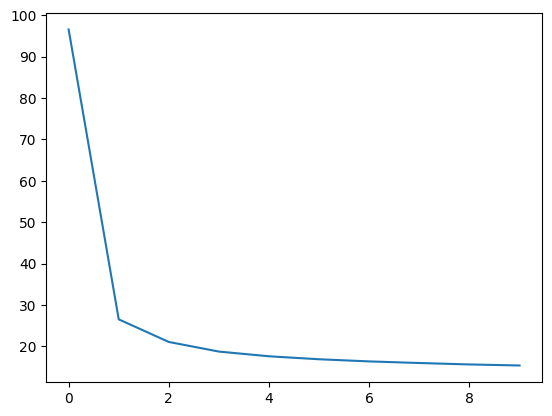

In [28]:
device = torch.device('cuda:0')
net = AE(10).to(device)
num_epochs = 10
lr = 1e-4
opt = optim.Adam(net.parameters(), lr=lr)
sch = ExponentialLR(opt, 0.9, verbose = True)

ls = []
for i in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        X = batch[0].to(device)
        X = X.view(-1, 784)
        Z, Xhat = net(X)
        loss = F.mse_loss(Xhat, X)
        total_loss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
    sch.step()

    ls.append(total_loss)

plt.plot(ls)

In [29]:
X = X.detach().cpu()
Xhat = Xhat.detach().cpu()

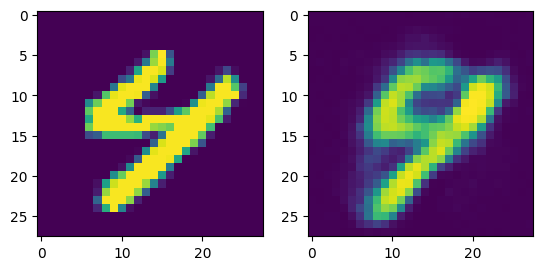

In [30]:
plt.subplot(121)
plt.imshow(X[1, :].reshape(28, 28))
plt.subplot(122)
plt.imshow(Xhat[1, :].reshape(28, 28))

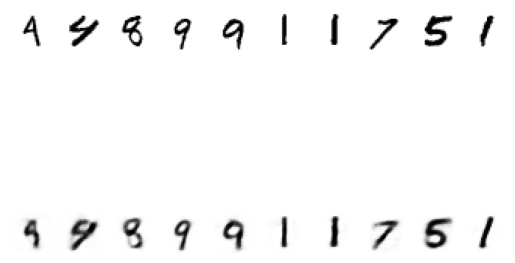

In [31]:
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(X[i, :].reshape(28, 28), cmap='gray_r')
    plt.axis('off')

    plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(Xhat[i, :].reshape(28, 28), cmap='gray_r')
    plt.axis('off')

plt.show()

In [32]:
total_loss = 0.0

# Calculate total loss for train loader
for batch in test_loader:
    X = batch[0].to(device)
    X = X.view(-1, 784)
    Z, Xhat = net(X)
    loss = F.mse_loss(Xhat, X)
    total_loss += loss.item()

# Print total loss for train loader
print("Total loss for test loader:", total_loss)



Total loss for test loader: 3.995493210852146


In [ ]:
X = X.detach().cpu()
Xhat = Xhat.detach().cpu()

In [ ]:
# Display 10 images from the test set
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(X[i, :].reshape(28, 28), cmap='gray_r')
    plt.axis('off')

    plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(Xhat[i, :].reshape(28, 28), cmap='gray_r')
    plt.axis('off')

plt.show()


# The rest is for the Encoder/decoder using CNNS

In [ ]:
batch_sz = 64  # this is batch size i.e. the number of rows in a batch of data
train_loader, valid_loader, test_loader = mnist(batch_sz)

In [ ]:
class AEUsingConv(nn.Module):
    def __init__(self, ndims):
        super().__init__()
        self.ndims = ndims
        self.econv1 = nn.Conv2d(1, 16, 3, 1, 1)
        self.ebn1 = nn.BatchNorm2d(16)
        self.econv2 = nn.Conv2d(16, 32, 3, 2, 1)
        self.ebn2 = nn.BatchNorm2d(32)
        self.econv3 = nn.Conv2d(32, 64, 3, 2, 1)
        self.ebn3 = nn.BatchNorm2d(64)
        self.elinear1 = nn.Linear(64 * 7 * 7, 100)
        self.ebn4 = nn.BatchNorm1d(100)
        self.elinear2 = nn.Linear(100, self.ndims)

        self.dlinear1 = nn.Linear(self.ndims, 100)
        self.dbn1 = nn.BatchNorm1d(100)
        self.dlinear2 = nn.Linear(100, 64 * 7 * 7)
        self.dbn2 = nn.BatchNorm1d(64 * 7 * 7)
        self.dconv1 = nn.ConvTranspose2d(64, 32, 3, 1, 1)
        self.dbn3 = nn.BatchNorm2d(32)
        self.dconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1)
        self.dbn4 = nn.BatchNorm2d(16)
        self.dconv3 = nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding=1)

    def encoder(self, x):
        x = torch.relu(self.econv1(x))
        x = self.ebn1(x)

        x = torch.relu(self.econv2(x))
        x = self.ebn2(x)

        x = torch.relu(self.econv3(x))
        x = self.ebn3(x)

        x = x.view(-1, 64 * 7 * 7)

        x = torch.relu(self.elinear1(x))
        x = self.ebn4(x)

        x = torch.sigmoid(self.elinear2(x))
        return x

    def decoder(self, x):
        x = torch.relu(self.dlinear1(x))
        x = self.dbn1(x)

        x = torch.relu(self.dlinear2(x))
        x = self.dbn2(x)
        x = x.view(-1, 64, 7, 7)
        x = torch.relu(self.dconv1(x))
        x = self.dbn3(x)

        x = torch.relu(self.dconv2(x))
        x = self.dbn4(x)
        x = torch.sigmoid(self.dconv3(x))
        return x

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return z, x

In [ ]:

device = torch.device('cuda')
netConv = AEUsingConv(10).to(device)
num_epochs = 10
lr = 1e-4
opt = optim.Adam(netConv.parameters(), lr=lr)

ls = []
for i in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        X = batch[0].to(device)
        Z, Xhat = netConv(X)
        loss = F.mse_loss(Xhat, X)
        total_loss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
    print(f"current loss {total_loss} for epoch {i}")
    ls.append(total_loss)

plt.plot(ls)

In [ ]:
X = X.detach().cpu()
Xhat = Xhat.detach().cpu()

In [ ]:
plt.subplot(121)
plt.imshow(X[1, :].reshape(28, 28))
plt.subplot(122)
plt.imshow(Xhat[1, :].reshape(28, 28))

In [ ]:
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(X[i, :].reshape(28, 28), cmap='gray_r')
    plt.axis('off')

    plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(Xhat[i, :].reshape(28, 28), cmap='gray_r')
    plt.axis('off')

plt.show()

In [ ]:
total_loss = 0.0

# Calculate total loss for train loader
for batch in test_loader:
    X = batch[0].to(device)
    Z, Xhat = netConv(X)
    loss = F.mse_loss(Xhat, X)
    total_loss += loss.item()

# Print total loss for train loader
print("Total loss for test loader:", total_loss)



In [ ]:
X = X.detach().cpu()
Xhat = Xhat.detach().cpu()

In [ ]:
# Display 10 images from the test set
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(X[i, :].reshape(28, 28), cmap='gray_r')
    plt.axis('off')

    plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(Xhat[i, :].reshape(28, 28), cmap='gray_r')
    plt.axis('off')

plt.show()


# Some fucked up shit, i don't get half of it


In [ ]:
class AEUsingConvAndSomeOtherShit(nn.Module):
    def __init__(self, ndims):
        super().__init__()
        self.ndims = ndims
        self.econv1 = nn.Conv2d(1, 16, 3, 1, 1)
        self.ebn1 = nn.BatchNorm2d(16)
        self.econv2 = nn.Conv2d(16, 32, 3, 2, 1)
        self.ebn2 = nn.BatchNorm2d(32)
        self.econv3 = nn.Conv2d(32, 64, 3, 2, 1)
        self.ebn3 = nn.BatchNorm2d(64)
        self.elinear1 = nn.Linear(64 * 7 * 7, 100)
        self.ebn4 = nn.BatchNorm1d(100)
        self.elinear2 = nn.Linear(100, self.ndims)

        self.dlinear1 = nn.Linear(self.ndims, 100)
        self.dbn1 = nn.BatchNorm1d(100)
        self.dlinear2 = nn.Linear(100, 64 * 7 * 7)
        self.dbn2 = nn.BatchNorm1d(64 * 7 * 7)
        self.dconv1 = nn.ConvTranspose2d(64, 32, 3, 1, 1)
        self.dbn3 = nn.BatchNorm2d(32)
        self.dconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1)
        self.dbn4 = nn.BatchNorm2d(16)
        self.dconv3 = nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding=1)

        self.plinear1 = nn.Linear(self.ndims, self.ndims)
        self.plinear2 = nn.Linear(self.ndims, self.ndims)

    def encoderHead(self, x):
        x = torch.relu(self.econv1(x))
        x = self.ebn1(x)

        x = torch.relu(self.econv2(x))
        x = self.ebn2(x)

        x = torch.relu(self.econv3(x))
        x = self.ebn3(x)

        x = x.view(-1, 64 * 7 * 7)

        x = torch.relu(self.elinear1(x))
        x = self.ebn4(x)

        x = torch.sigmoid(self.elinear2(x))
        return x

    def get_params(self, x):
        mu = self.plinear1(x)
        logvar = self.plinear2(x)
        return mu, logvar

    def encoder(self, x):
        x = self.encoderHead(x)
        mu, logvar = self.get_params(x)
        z = torch.exp(logvar * 0.5) * torch.randn_like(logvar) + mu
        return z, mu, logvar

    def decoder(self, x):
        x = torch.relu(self.dlinear1(x))
        x = self.dbn1(x)

        x = torch.relu(self.dlinear2(x))
        x = self.dbn2(x)
        x = x.view(-1, 64, 7, 7)
        x = torch.relu(self.dconv1(x))
        x = self.dbn3(x)

        x = torch.relu(self.dconv2(x))
        x = self.dbn4(x)
        x = torch.sigmoid(self.dconv3(x))
        return x

    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        x = self.decoder(z)
        return z, x, mu, logvar

In [ ]:
def get_loss(x, xhat, mu, logvar):
    m = 1e-4
    recon_loss = F.mse_loss(x, xhat)
    kld_loss = torch.mean(torch.sum(-0.5 * (1 + logvar - torch.exp(logvar) - mu ** 2), dim=1), dim=0)
    loss = m * kld_loss + (1 - m) * recon_loss
    return loss

In [ ]:

device = torch.device('cuda')
netConvStableShit = AEUsingConvAndSomeOtherShit(20).to(device)
num_epochs = 25
lr = 1e-4
opt = optim.Adam(netConvStableShit.parameters(), lr=lr)

ls = []
for i in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        X = batch[0].to(device)
        Z, Xhat, mu, logvar = netConvStableShit(X)
        loss = get_loss(Xhat, X, mu, logvar)
        total_loss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
    print(f"current loss {total_loss} for epoch {i}")
    ls.append(total_loss)

plt.plot(ls)

In [ ]:
num_samples = 64
z = torch.randn((num_samples, 20)).to(device)
with torch.no_grad():
    Xhat = netConvStableShit.decoder(z)

In [ ]:
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(Xhat.cpu()[i, 0, :, :], cmap='gray')